In [5]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = [5, 5]
from scipy import integrate, optimize
from scipy.stats import norm
from scipy.stats import uniform
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')
import corner
import emcee
import time
import dynesty

In [6]:
data = np.load(r"C:\Users\Admin\reps\astrostatistics_bicocca_2024\solutions\transient.npy")

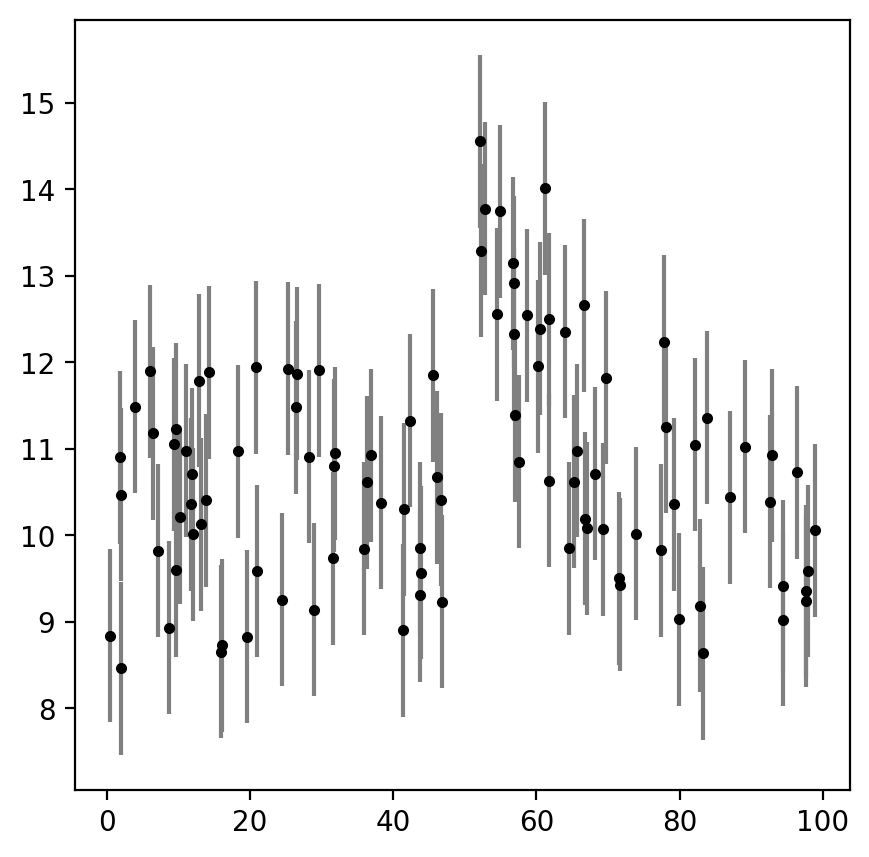

In [7]:
time = data[:,0]
flux = data[:,1]
uncertanties = data[:,2]
plt.errorbar(time, flux, yerr = uncertanties, fmt = '.k', ecolor = 'gray')
plt.show()

In [11]:
def model(time, b, A, a, t_0):
    return np.where(time<t_0, b, b + A*np.exp(-a*(time-t_0))) #burst model

In [22]:
popt, pcov = optimize.curve_fit(model, time, flux, p0 = [10.0, 5.0, 1, 50.0]) #estimation of parameters using non-linear least squares.

In [23]:
print(popt)

[10.28787966  4.39381689  0.11890637 50.96637913]


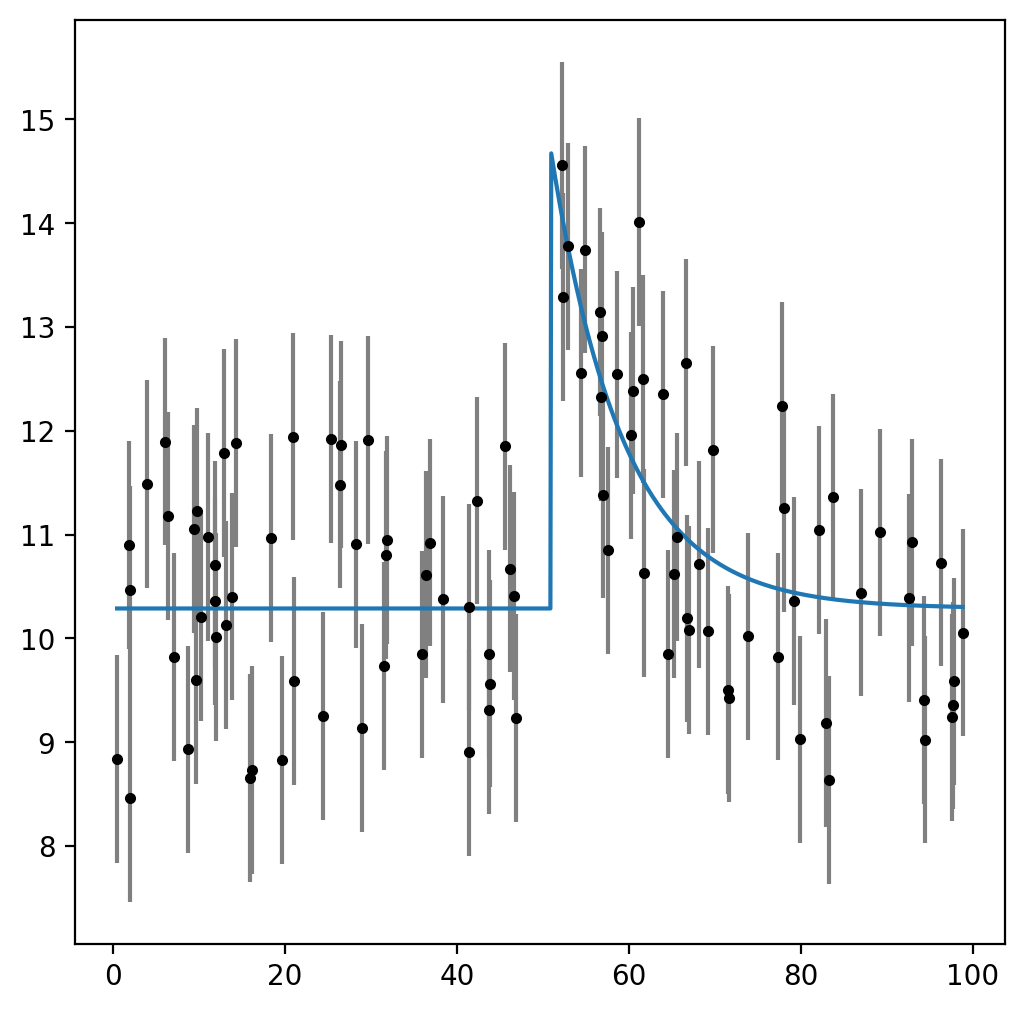

In [24]:
fig = plt.figure(figsize = (6,6))
plt.errorbar(time, flux, yerr = uncertanties, fmt = '.k', ecolor = 'gray')
x_fit = np.linspace(min(time), max(time), 1000)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]))

# MCMC

In [25]:
def log_likelihood(theta, time, flux, uncertanties):
    b, A, a, t_0 = theta
    return -0.5 * np.sum((flux - model(time, b, A, a, t_0)) ** 2 / uncertanties + np.log(uncertanties))

def log_prior(theta):
    b, A, a, t_0 = theta
    if 0.0 < b < 50.0 and 0.0 < A < 50.0 and 0.0 < t_0 < 100.0 and -5.0 < np.log(a) < 5.0:
        return 0.0 - np.log(a)
    return -np.inf

def log_probability(theta, time, flux, uncertanties):
    b, A, a, t_0 = theta
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, time, flux, uncertanties)

In [26]:
start_pos = popt + 1e-4 * np.random.randn(32, 4) #starting guesses from the curve_fit values with 32 walkers and 4 dimensions 
nwalkers, ndim = start_pos.shape
nsteps = 10000

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args = (time, flux, uncertanties)
)
sampler.run_mcmc(start_pos, nsteps, progress=True);

100%|██████████| 10000/10000 [00:36<00:00, 276.28it/s]


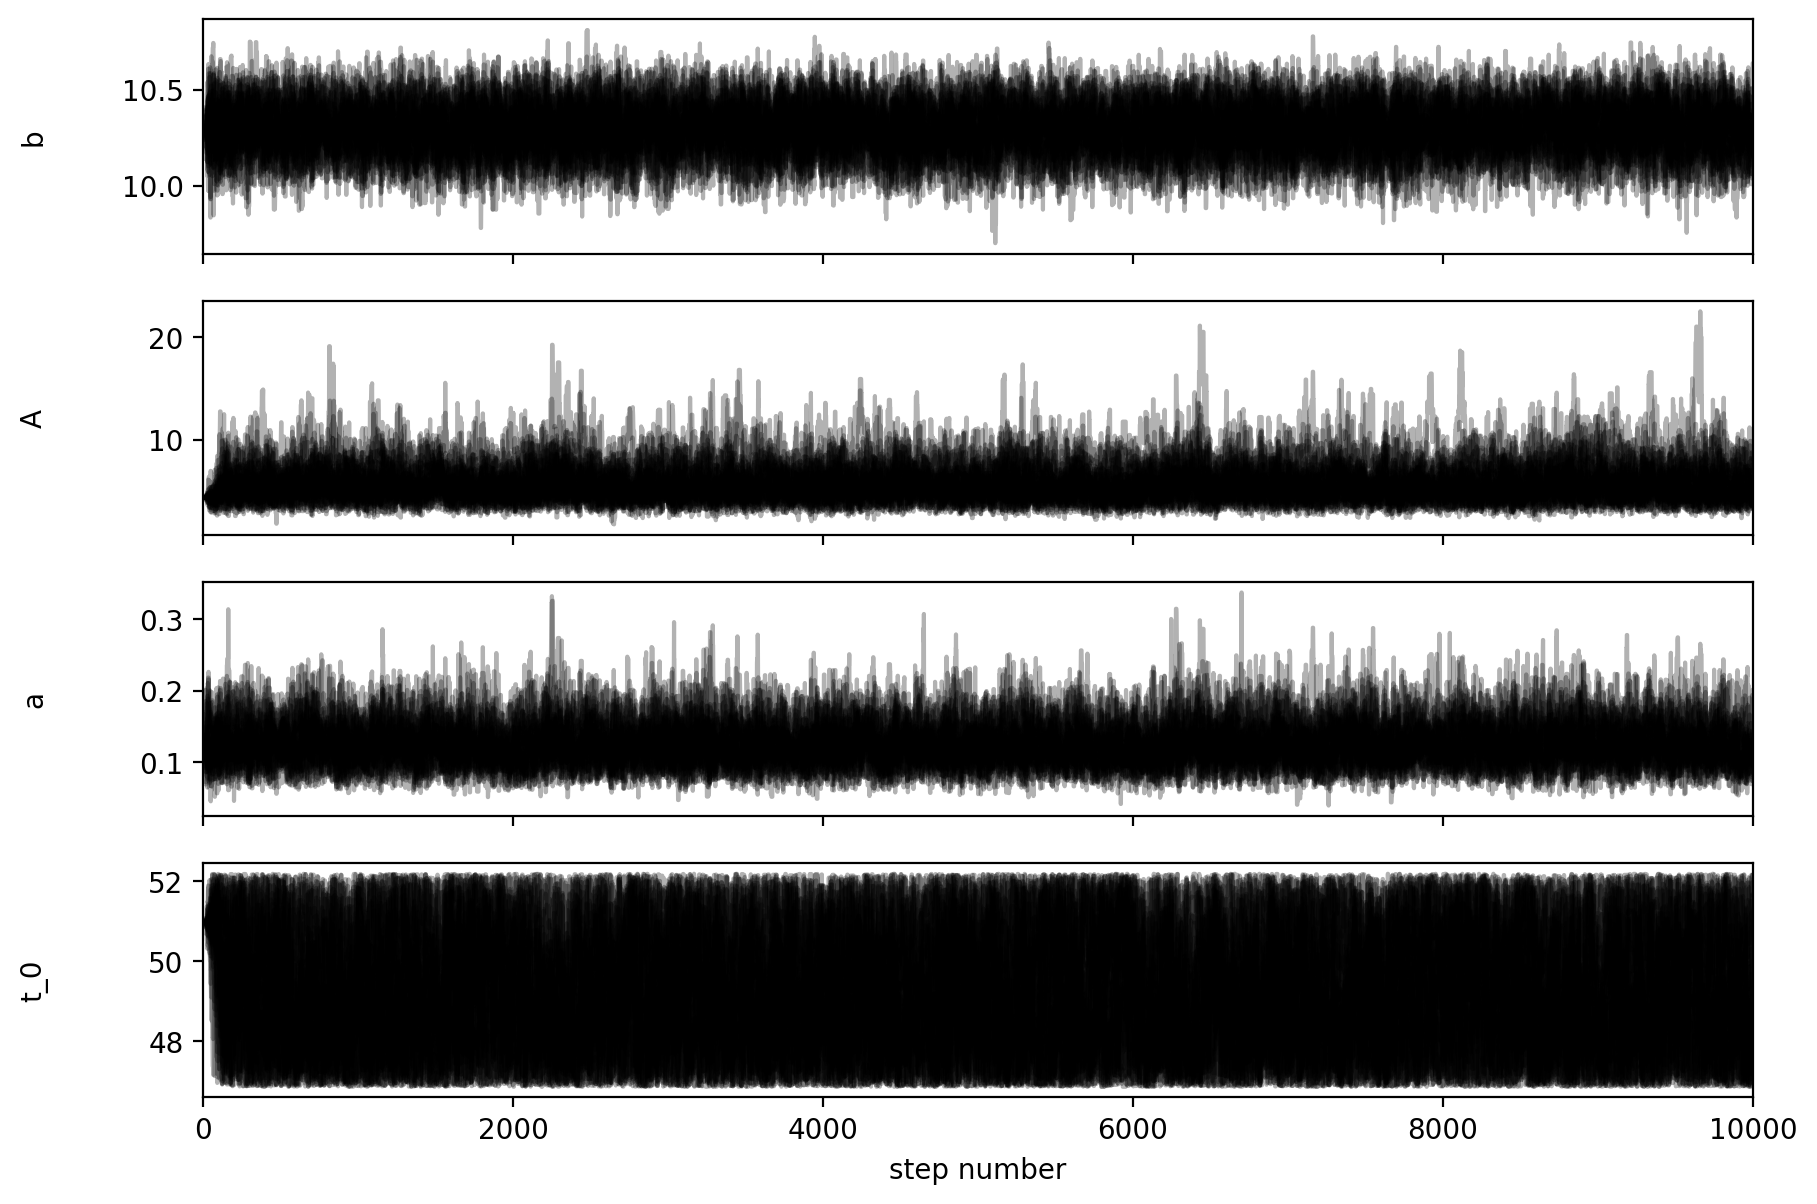

In [27]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["b", "A", "a", "t_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

We started near to the ML so we can set a small burn-in. We can also compute the autocorrelation time to thin the chain.

In [29]:
burn = 50
tau = sampler.get_autocorr_time()
print(tau)

[56.95523979 72.43320008 59.99604575 76.05835187]


In [30]:
flat_samples = sampler.get_chain(discard=burn, thin = int(np.mean(tau)), flat=True)
print(flat_samples.shape)

(4800, 4)


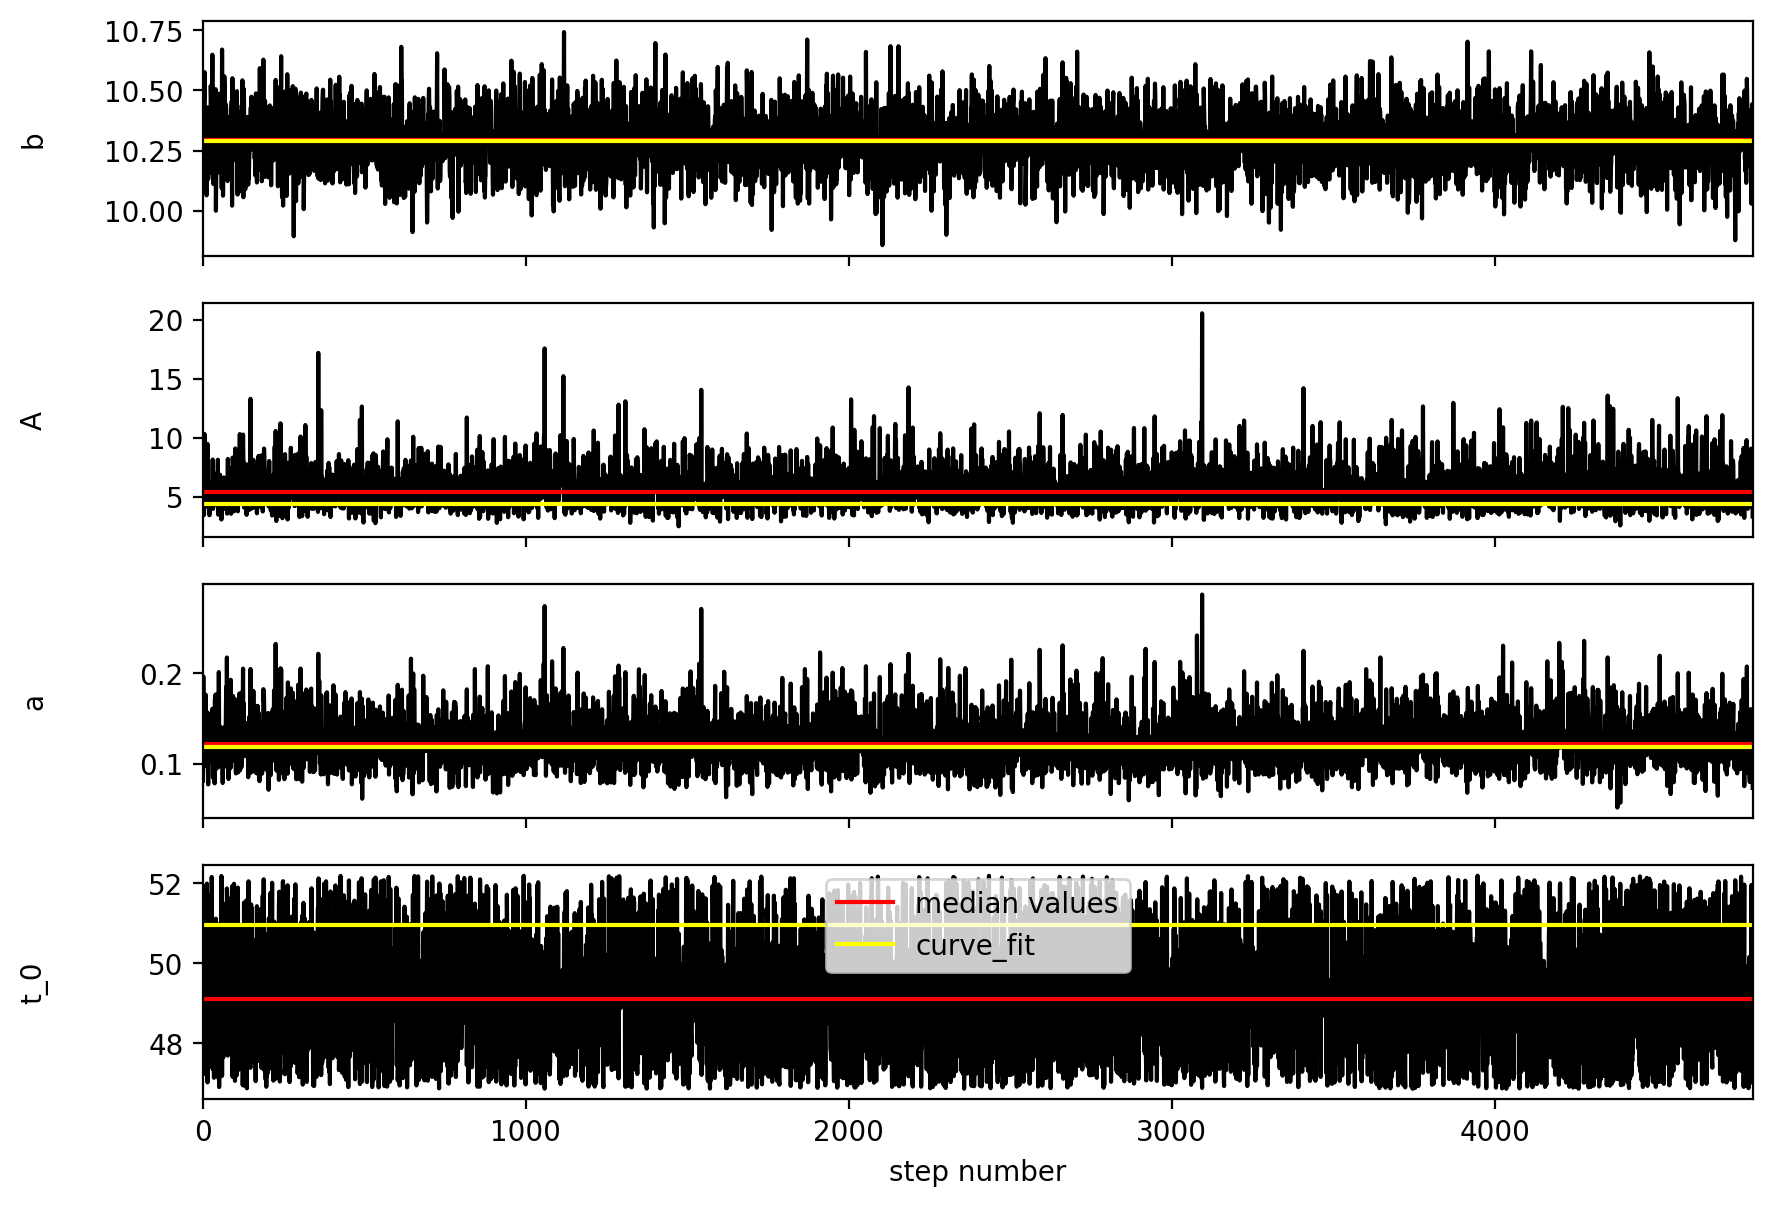

In [47]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
labels = ["b", "A", "a", "t_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, i], "k")
    ax.set_xlim(0, len(flat_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.axhline(np.median(flat_samples[:, i]), color = 'red', label = 'median values')
    ax.axhline(popt[i], color = 'yellow', label = 'curve_fit')
axes[-1].set_xlabel("step number")
plt.legend();

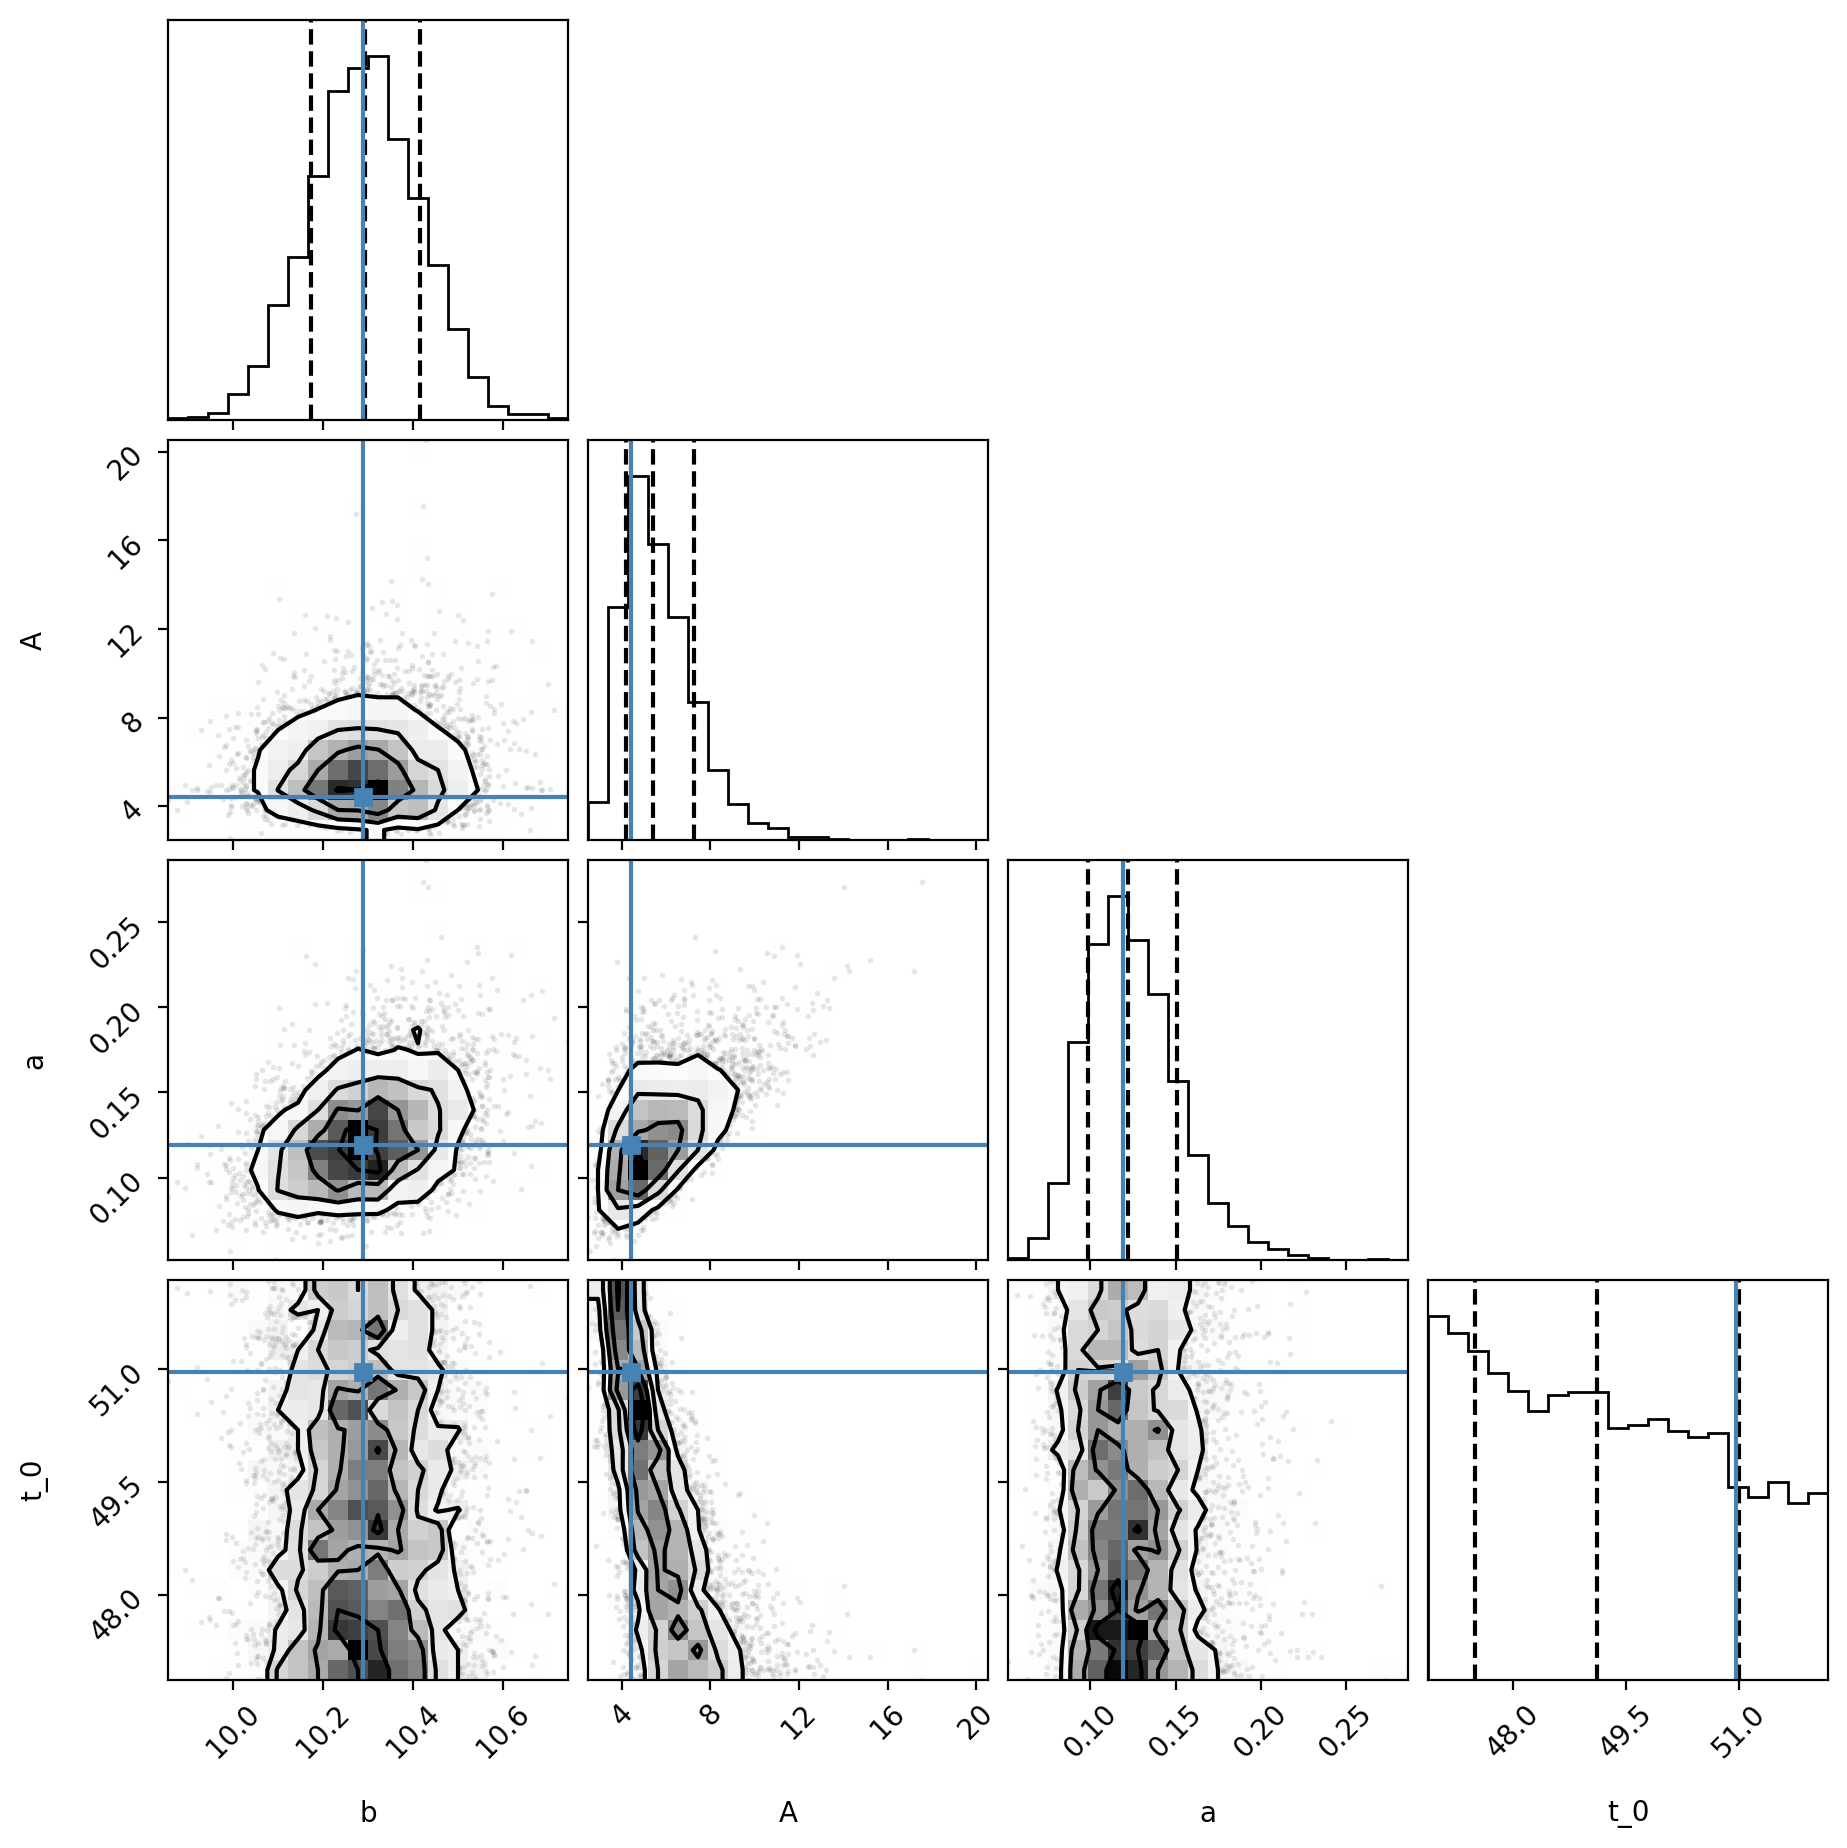

In [46]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[popt[0], popt[1], popt[2], popt[3]], quantiles = [0.16, 0.5, 0.84]
); # in blue there are the curve_fit best parameters

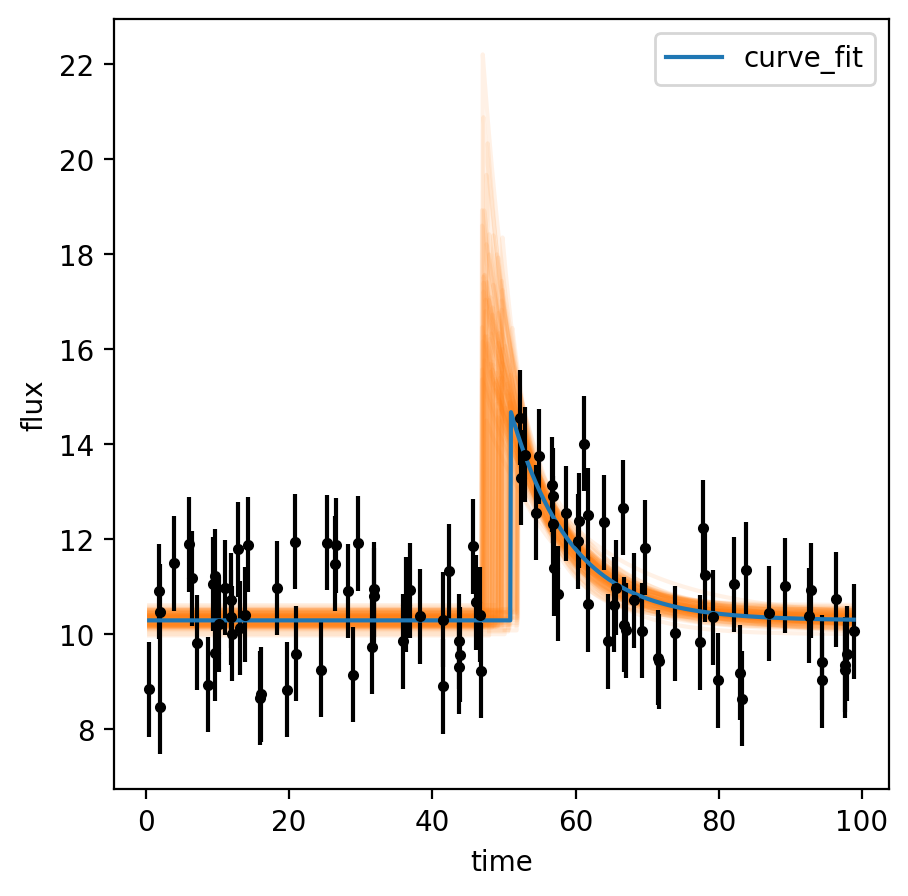

In [49]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_fit, model(x_fit, sample[0], sample[1], sample[2], sample[3]), "C1", alpha=0.1) #plotting some samples
    
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="curve_fit")
plt.legend()

plt.xlabel("time")
plt.ylabel("flux");

In [45]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
#These doesn't represent the best model parameters, but they are statistics of the marginalized distributions

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can compute the maximum a posteriori

In [48]:
log_prob = sampler.get_log_prob(discard=burn, thin=int(np.mean(tau)), flat=True)
max_posterior = flat_samples[np.argmax(log_prob)]
print('Maxima a posteriori = ', max_posterior)

Maxima a posteriori =  [10.28124482  6.59120118  0.11490676 47.27567434]


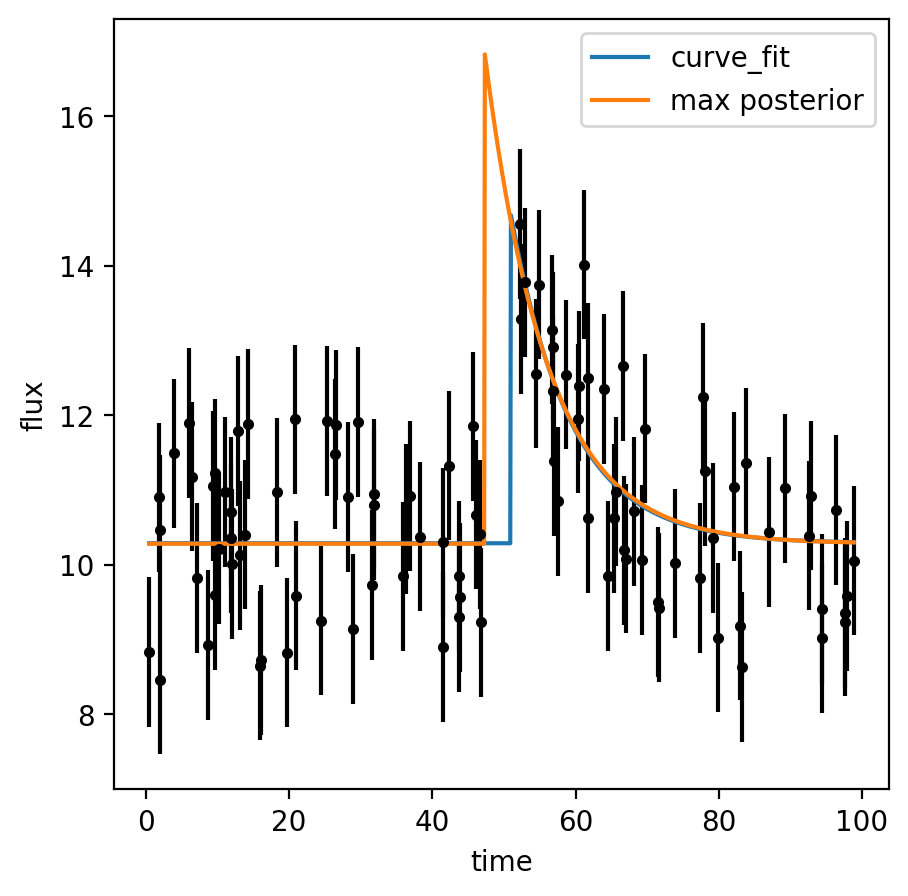

In [50]:
plt.errorbar(time, flux, yerr=uncertanties, fmt=".k", capsize=0)
plt.plot(x_fit, model(x_fit, popt[0], popt[1], popt[2], popt[3]), label="curve_fit")
plt.plot(x_fit, model(x_fit, max_posterior[0], max_posterior[1], max_posterior[2], max_posterior[3]), label="max posterior")
plt.legend()

plt.xlabel("time")
plt.ylabel("flux");